## **멜론 차트**에서 연도별로 상위 50곡의 **가사**를 크롤링하고, 각 곡에 대해 **감정 분석**을 수행하여 **연도별 감정 점수**를 시각화

1. **웹 크롤링**:
   - 멜론 차트에서 2018년부터 2023년까지의 **연도별 상위 50곡** 정보를 크롤링합니다.
   - 각 곡의 **곡명**, **가수**, **곡 ID**, **가사**를 추출하여 데이터를 수집합니다.
   - 곡 ID를 기반으로 **곡 상세 페이지**에 요청을 보내고, 해당 페이지에서 가사를 크롤링합니다.

2. **감정 분석**:
   - 수집한 **가사**를 기반으로, **TextBlob** 라이브러리를 사용해 **감정 점수**를 계산합니다.
   - 각 곡의 가사를 하나의 문자열로 합친 뒤 **sentiment.polarity** 값을 이용해 감정 점수를 계산하고, 이를 DataFrame에 **sentiment_score** 컬럼으로 추가합니다.

3. **연도별 평균 감정 점수 계산**:
   - 각 연도별로 감정 점수의 **평균**을 계산하고, 이를 **avg_sentiment_df**라는 DataFrame에 저장합니다.

4. **시각화**:
   - **Seaborn**과 **Matplotlib**를 사용하여 연도별 **평균 감정 점수**를 **라인 그래프**로 시각화합니다.

5. **특이사항**:
   - 2019년의 감정 점수가 상대적으로 낮은 이유는 **사재기 논란**과 관련이 있습니다. 해당 연도의 차트 상위 곡들은 대체로 **슬픈 발라드**곡들이었고, 그로 인해 감정 분석에서 **부정적인 점수**가 많이 나왔습니다.


### **1.웹 크롤링**  

멜론 사이트는 **동적 사이트**가 아닌 **정적 사이트**로, 데이터를 JSON 형태로 요청하는 것이 아니라 HTML 파일을 다시 받아오는 방식으로 정보를 업데이트합니다. 이 때문에 **BeautifulSoup**을 이용하여 HTML 데이터를 파싱하고 필요한 정보를 추출해야 합니다.




In [20]:
import pandas as pd
import requests
import re
from bs4 import BeautifulSoup


#### **2018년부터 2023년까지의 연도별 멜론 차트 Top 50 데이터를 가사와 함께 반복해서 크롤링**

In [21]:
url = 'https://www.melon.com/chart/age/list.htm'
headers = {
    'User-Agent': ('Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 '
                   '(KHTML, like Gecko) Chrome/68.0.3440.75 Safari/537.36')
}

# 연도 리스트 (2018부터 2023까지)
years = [str(year) for year in range(2018, 2024)]



#### **About URL, header, Params**

1. **URL**:  
   `url` 변수는 멜론 차트 페이지의 주소로, 연도별 차트를 조회하는 페이지를 지정합니다.

2. **헤더**:  
   `headers`는 요청 헤더로, 웹 브라우저와 유사한 `User-Agent` 값을 사용하여 서버에서 요청을 정상적으로 처리하도록 합니다.

3. **파라미터**:  
   `params` 딕셔너리는 URL에 추가될 쿼리 파라미터를 정의합니다.  
   - `idx`: 요청하는 차트의 구분 값으로 '1'은 기본 차트를 의미합니다.  
   - `chartType`: `'YE'`는 연도별 차트를 요청한다는 뜻입니다.  
   - `chartGenre`: `'KPOP'`은 장르를 한국 가요로 설정합니다.  
   - `chartDate`: `'2023'`은 2023년 차트를 요청한다는 의미입니다.  
   - `moved`: `'Y'`는 데이터를 이동시켜 최신 순으로 정렬합니다.



---

**BeautifulSoup을 사용한 HTML 파싱**  
- `BeautifulSoup`을 사용하여 멜론 차트 페이지의 HTML을 파싱합니다.  
- `select('.lst50')`는 **.lst50** 클래스를 가진 모든 HTML 요소를 찾아 리스트로 반환합니다. 이 클래스는 Top 50 곡들의 정보를 포함하는 요소입니다.

**DataFrame 준비**  
- `columns` 리스트를 정의하여 DataFrame의 열 이름을 설정합니다.  
- `kpop_2023` DataFrame을 준비합니다. 이 DataFrame에는 각 곡의 제목(title), 가수(singer), 가사(lyric) 정보가 담길 것입니다.

**각 곡에 대한 정보 추출**  
- `for element in elements:`는 `.lst50` 클래스를 가진 각 곡에 대해 반복합니다.  
- 곡의 ID를 추출하는 부분입니다. `select('a[onclick*=SongDetail]')`를 통해 곡의 상세 페이지로 이동하는 링크를 찾고, 정규 표현식을 사용해 곡 ID를 추출합니다.  
- 추출한 곡 ID를 이용하여 곡의 상세 페이지 URL을 생성합니다.

**곡의 가사 추출**  
- `requests.get()`을 사용하여 곡의 상세 페이지로 요청을 보냅니다.  
- 곡의 가사를 포함하는 `.lyric` 클래스를 선택하고, `<br/>` 태그를 기준으로 가사를 분리합니다.  
- 가사에 불필요한 빈 항목을 제거하여 **lyrics** 리스트를 만듭니다.

**곡명과 가수 추출**  
- 곡명은 `.rank01` 클래스를 통해 추출하고, 가수는 `.rank02 > a`를 통해 추출합니다.  
- `.text.strip()`을 사용하여 불필요한 공백을 제거합니다.

**데이터 저장**  
- 추출한 곡명, 가수, 곡 ID, 가사를 하나의 딕셔너리로 저장합니다.  
- 이 딕셔너리를 `kpop_50` 리스트에 추가합니다.

In [22]:
# 연도별 데이터프레임을 저장할 딕셔너리
dataframes = {}

# 각 연도에 대해 크롤링 진행
for year in years:
    print(f"Processing data for {year}")

    # URL 파라미터 설정
    params = {
        'idx': '1',
        'chartType': 'YE',  # 10년 단위로 검색하는 부분과 연관
        'chartGenre': 'KPOP',  # 가요검색: KPOP
        'chartDate': year,   # 검색연도
        'moved': 'Y',
    }

    # 요청 보내고 BeautifulSoup로 파싱
    response = requests.get(url, params=params, headers=headers)
    dom_list = BeautifulSoup(response.text, 'html.parser')
    elements = dom_list.select('.lst50')  # lst50 클래스를 가진 element 전부를 List로 리턴

    # 각 연도에 대한 데이터프레임 초기화
    kpop_data = []

    # 각 곡에 대해 데이터 수집
    for element in elements:
        # 곡 ID 추출
        song_id_html = str(element.select('a[onclick*=SongDetail]'))
        matched = re.search(r"\'(\d+)\'", song_id_html)
        song_id = matched.group(1) if matched else None
        song_url = f'https://www.melon.com/song/detail.htm?songId={song_id}'

        # 곡 정보 페이지로 요청하여 가사 추출
        song_response = requests.get(song_url, headers=headers)
        song_soup = BeautifulSoup(song_response.text, 'html.parser')

        lyric = song_soup.select('.lyric')[0]
        lyrics = str(lyric).split('<br/>')[1:-1]
        lyrics = [i for i in lyrics if i ]

        # 곡명, 아티스트 추출
        song_name = element.select_one('.rank01').text.strip()
        singer = element.select_one('.rank02 > a').text.strip()

        # 데이터 저장
        data = {
            'song_name': song_name,
            'singer': singer,
            'song_id': song_id,
            'lyrics': lyrics
        }
        kpop_data.append(data)

    print(f"Number of items collected for {year}: {len(kpop_data)}")

    # 각 연도에 대한 DataFrame 생성
    df = pd.DataFrame(kpop_data)

    # 딕셔너리에 연도별 DataFrame 저장
    dataframes[year] = df

    # 각 연도의 데이터프레임 확인
    print(f"Data for {year} collected:")
    print(df.head())
    print(f"Shape of {year} data: {df.shape}\n")

Processing data for 2018
Number of items collected for 2018: 50
Data for 2018 collected:
                               song_name           singer   song_id  \
0                 사랑을 했다 (LOVE SCENARIO)             iKON  30859584   
1                                   그날처럼              장덕철  30755375   
2  모든 날, 모든 순간 (Every day, Every Moment)               폴킴  30962526   
3                                   지나오다         닐로(Nilo)  30699142   
4                                     뿜뿜  모모랜드 (MOMOLAND)  30816860   

                                              lyrics  
0  [지우지 못할 추억이 됐다 , 볼만한 멜로드라마 , 괜찮은 결말 , 그거면 됐다 널...  
1  [넌 어떻게 사는지 참 궁금해, 날 걱정하는 사람들에게, 다 잊었단 거짓말하는 내가...  
2  [생각만 해도 눈물이나, 힘든 시간 날 지켜준 사람, 이제는 내가 그댈 지킬 테니,...  
3  [여전히 내 하루는 온통 네 생각에, 뜬 눈으로 밤을 지새고, 난 두려워 시간이 쌓...  
4  [랑데뷰, 내 마음을 들었다 놨다 해 맘대루 , 맘대루, 지금 내 눈엔 눈엔 눈엔,...  
Shape of 2018 data: (50, 4)

Processing data for 2019
Number of items collected for 2019: 50
Data for 2019 collected:
                                   s

In [23]:
print(f"Number of items in dataframes: {len(dataframes)}")


Number of items in dataframes: 6


가수들의 감정점수출력

데이터프레임 하나로 합치기

## **감정분석**

**각 연도의 곡 가사에 대해 감정 분석을 수행하고, 감정 점수를 계산하여 각 DataFrame에 추가  

각 가사의 감정 점수는 `TextBlob`을 사용해 계산되며, 결과는 `'sentiment_score'` 컬럼에 저장됩니다.**

In [ ]:
from textblob import TextBlob

# 각 연도에 대해 이미 존재하는 dataframes에서 감정 분석 수행
for year, df in dataframes.items():
    print(f"Processing sentiment analysis for {year}")

    # 가사 컬럼이 비어있지 않은 경우에만 분석
    if 'lyrics' in df.columns:
        sentiment_scores = []

        # 각 곡에 대해 감정 분석
        for lyrics in df['lyrics']:
            lyric_text = ' '.join(lyrics)  # 가사를 하나의 문자열로 합침
            blob = TextBlob(lyric_text)
            sentiment_score = blob.sentiment.polarity  # 감정 점수 (polarity 값)
            sentiment_scores.append(sentiment_score)

        # 감정 점수 컬럼 추가
        df['sentiment_score'] = sentiment_scores
        dataframes[year] = df  # 딕셔너리에 업데이트

        # 결과 출력
        print(f"Sentiment analysis complete for {year}")
        print(df[['song_name', 'sentiment_score']].head())
        print(f"Shape of {year} data after adding sentiment score: {df.shape}\n")

# 모든 연도의 감정 분석 결과 출력
for year, df in dataframes.items():
    print(f"\n{year} DataFrame with sentiment scores:")
    print(df[['song_name', 'sentiment_score']].head())


Processing sentiment analysis for 2018
Sentiment analysis complete for 2018
                               song_name  sentiment_score
0                 사랑을 했다 (LOVE SCENARIO)         0.500000
1                                   그날처럼         0.000000
2  모든 날, 모든 순간 (Every day, Every Moment)         0.000000
3                                   지나오다         0.000000
4                                     뿜뿜         0.233333
Shape of 2018 data after adding sentiment score: (50, 5)

Processing sentiment analysis for 2019
Sentiment analysis complete for 2019
                                   song_name  sentiment_score
0                  사랑에 연습이 있었다면 (Prod. 2soo)         0.000000
1                                    그때가 좋았어         0.000000
2  작은 것들을 위한 시 (Boy With Luv) (Feat. Halsey)         0.435952
3                                       넘쳐흘러         0.000000
4      모든 날, 모든 순간 (Every day, Every Moment)         0.000000
Shape of 2019 data after adding sentiment score: (50, 5)

Processing s

### **각 연도별로 감정 점수의 평균을 계산하여 데이터프레임으로 저장**

In [ ]:
# 각 연도별 감정 점수 평균을 구할 리스트
avg_sentiment_scores = []

# 각 연도의 DataFrame에서 평균 감정 점수 계산
for year, df in dataframes.items():
    avg_score = df['sentiment_score'].mean()  # 감정 점수 평균 계산
    avg_sentiment_scores.append((year, avg_score))

# DataFrame으로 변환
avg_sentiment_df = pd.DataFrame(avg_sentiment_scores, columns=['Year', 'Average Sentiment'])


**각 연도별 감정점수의 평균**

In [ ]:
# 평균 감정 점수 출력
print(avg_sentiment_df)

   Year  Average Sentiment
0  2018           0.123921
1  2019           0.072234
2  2020           0.118092
3  2021           0.108588
4  2022           0.112324
5  2023           0.126747


In [ ]:
# CSV 파일로 저장
avg_sentiment_df.to_csv('avg_sentiment_by_year.csv', index=False)

각 연도별 데이터프레임에 'Year' 컬럼을 추가한 후, 모든 데이터프레임을 하나로 합칩니다.

In [ ]:
for year, df in dataframes.items():
    df['Year'] = year  # 각 데이터프레임에 'Year' 컬럼 추가

# 모든 데이터프레임을 하나로 합침
all_data = pd.concat(dataframes.values(), ignore_index=True)

# 결과 출력
all_data.head()

# 'all_data' 데이터프레임을 CSV 파일로 저장
all_data.to_csv('melon_combined_data.csv', index=False)

print("Data saved to 'combined_data.csv'")

Data saved to 'combined_data.csv'


## **시각화 (개선 전)**

5년간 차트에 가장 많이 등장한 아티스트

In [1]:
import pandas as pd
all_data = pd.read_csv('/content/melon_combined_data.csv')

In [115]:
# 전체 가수별 등장 횟수 계산
total_artist_counts = all_data.groupby('singer').size().reset_index(name='count')

# 등장 횟수 내림차순으로 정렬 후 상위 5명 선택
top_5_artists = total_artist_counts.sort_values(by='count', ascending=False).head(5)

# 결과 출력
print("Top 5 artists by appearances:")
top_5_artists.head()

Top 5 artists by appearances:


,singer,count
63,방탄소년단,23
83,아이유,14
132,폴킴,12
24,NewJeans,8
101,임영웅,7


**차트에 많이 등장한 5명의 감정점수 변화**를 시각화합니다.


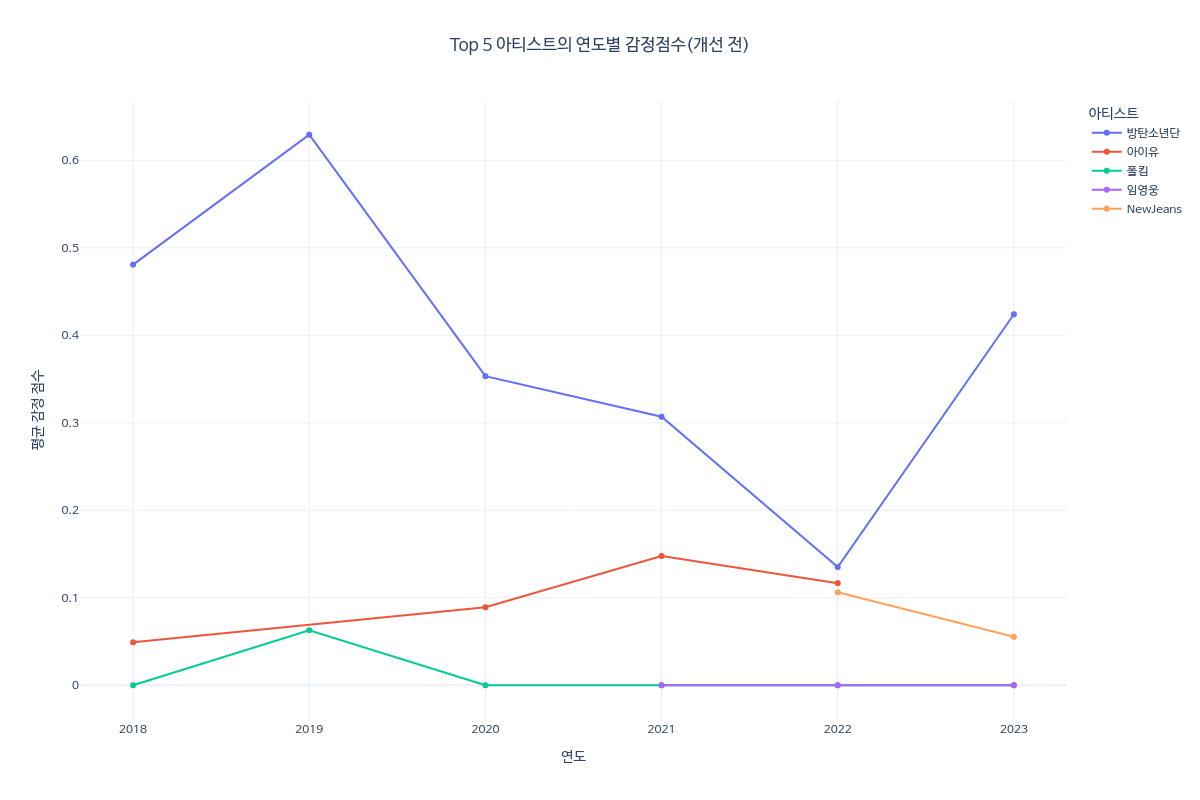

In [3]:
#개선 전이라고 작성하자

import plotly.express as px

# 특정 가수들의 리스트
top_5_singers = ['방탄소년단', '아이유', '폴킴', 'NewJeans', '임영웅']

# 해당 가수들의 데이터 필터링
filtered_data = all_data[all_data['singer'].isin(top_5_singers)]

# 연도별, 가수별 평균 감정 점수 계산
avg_sentiment_by_year = filtered_data.groupby(['Year', 'singer'])['sentiment_score'].mean().reset_index()

# Plotly 시각화
fig = px.line(avg_sentiment_by_year,
              x='Year',
              y='sentiment_score',
              color='singer',
              markers=True,
              title='Top 5 아티스트의 연도별 감정점수(개선 전)',
              labels={'sentiment_score': 'Average Sentiment Score', 'Year': 'Year'},
              template='plotly_white')

# 그래프 스타일 및 크기 조정
fig.update_layout(
    font_family="NanumBarunGothic",
    legend_title="아티스트",
    xaxis=dict(title="연도", tickangle=0),
    yaxis=dict(title="평균 감정 점수"),
    width=1200,  # 그래프 너비
    height=800,  # 그래프 높이
    title_x=0.5
)

# PNG로 렌더링 옵션
fig.show(renderer="png")  # PNG로 렌더링


In [5]:
avg_sentiment_df = pd.read_csv('/content/avg_sentiment_by_year.csv')

**연도별 평균 감정 점수(Average Sentiment Score)**를 나타내는 **선 그래프(Line Plot)입니다.**


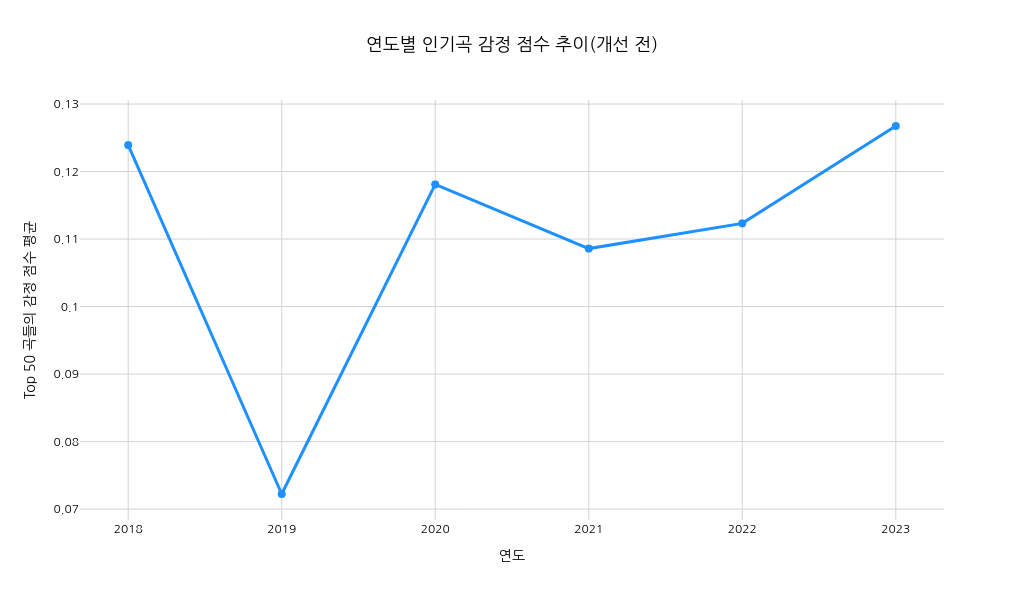

In [7]:
#개선 전이라고 작성하자

import plotly.graph_objects as go

# 시각화 (Line Plot)
fig = go.Figure()

# Line Plot 추가
fig.add_trace(go.Scatter(
    x=avg_sentiment_df['Year'],
    y=avg_sentiment_df['Average Sentiment'],
    mode='lines+markers',
    line=dict(color='dodgerblue', width=3),
    marker=dict(color='dodgerblue', size=8)
))

# 그래프 제목과 레이블 설정
fig.update_layout(
    title='연도별 인기곡 감정 점수 추이(개선 전)',
    xaxis_title='연도',
    yaxis_title='Top 50 곡들의 감정 점수 평균',
    title_font_size=18,
    title_font=dict(family="NanumGothic", size=18, color="black"),
    title_x=0.5,
    xaxis_tickangle=45,
    font=dict(family="NanumGothic", size=12, color="black"),
    plot_bgcolor="white",
    paper_bgcolor="white",
    xaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray', tickangle=0),
    yaxis=dict(showgrid=True, gridwidth=1, gridcolor='lightgray'),
    showlegend=False,  # 범례 제거
    width=1024,
    height=600
)

fig.show(renderer="png")


## **잘못된 분석**




>  2019년의 감정 점수가 낮았던 이유는 **사재기 논란**과 관련이 있다고 예상합니다. 사재기 의혹을 받았던 곡들은 대부분 **슬픈 발라드**곡들이었는데, 이 곡들은 감정적으로 **부정적인 감정**을 표현하기 때문에 감정 분석에서 **낮은 점수**를 받았습니다. 슬픈 발라드곡들은 **슬픔, 아픔, 이별** 등의 감정을 다루기 때문에, 그로 인해 **감정 점수**가 낮게 나오는 경향이 있었습니다. 따라서, 2019년 차트 상위권에 있던 사재기 곡들이 주로 슬픈 발라드였기 때문에 감정 점수가 낮았다고 예상합니다.




### **문제점:**
현재 사용한 감정 분석 라이브러리인 **TextBlob**에서는 많은 곡들이 **0점**으로 분류되고 있습니다. 이는 **TextBlob**의 감정 분석이 단순한 규칙 기반 방식에 의존하기 때문에, 특히 한국어 가사나 복잡한 문맥을 제대로 파악하지 못하고 감정 점수를 부정확하게 산출할 수 있기 때문이라 예상합니다. 이런 한계로 인해, 많은 곡들이 감정 점수 **0**으로 분류된 것으로 보입니다.

### **향후 계획:**
따라서, **GPT API**를 이용한 보다 정교한 감정 분석을 진행할 예정입니다.

# **개선된 버전**

## 개선 전 vs 개선 후

- **개선 전**: 가사 데이터를 한 번에 감정 분석하여 전체 가사에 대한 감정 점수를 계산했습니다.
- **개선 후**: 가사를 `|` 구분자로 나누어 각 줄에 대해 감정 분석을 진행한 뒤, 그 평균값을 계산하여 전체 가사의 감정 점수를 도출합니다.


In [106]:
import pandas as pd
melon_combined_data = pd.read_csv('/content/melon_combined_data.csv')


In [107]:
melon_combined_data.head()

,song_name,singer,song_id,lyrics,sentiment_score,Year
0,사랑을 했다 (LOVE SCENARIO),iKON,30859584,"['지우지 못할 추억이 됐다 ', '볼만한 멜로드라마 ', '괜찮은 결말 ', '그...",0.500000,2018
1,그날처럼,장덕철,30755375,"['넌 어떻게 사는지 참 궁금해', '날 걱정하는 사람들에게', '다 잊었단 거짓말...",0.000000,2018
2,"모든 날, 모든 순간 (Every day, Every Moment)",폴킴,30962526,"['생각만 해도 눈물이나', '힘든 시간 날 지켜준 사람', '이제는 내가 그댈 지...",0.000000,2018
3,지나오다,닐로(Nilo),30699142,"['여전히 내 하루는 온통 네 생각에', '뜬 눈으로 밤을 지새고', '난 두려워 ...",0.000000,2018
4,뿜뿜,모모랜드 (MOMOLAND),30816860,"['랑데뷰', '내 마음을 들었다 놨다 해 맘대루 ', '맘대루', '지금 내 눈엔...",0.233333,2018


개선전의 점수는 None값으로 바꿉니다.

In [108]:
melon_combined_data['sentiment_score'] = None


In [109]:
melon_combined_data.head()

,song_name,singer,song_id,lyrics,sentiment_score,Year
0,사랑을 했다 (LOVE SCENARIO),iKON,30859584,"['지우지 못할 추억이 됐다 ', '볼만한 멜로드라마 ', '괜찮은 결말 ', '그...",None,2018
1,그날처럼,장덕철,30755375,"['넌 어떻게 사는지 참 궁금해', '날 걱정하는 사람들에게', '다 잊었단 거짓말...",None,2018
2,"모든 날, 모든 순간 (Every day, Every Moment)",폴킴,30962526,"['생각만 해도 눈물이나', '힘든 시간 날 지켜준 사람', '이제는 내가 그댈 지...",None,2018
3,지나오다,닐로(Nilo),30699142,"['여전히 내 하루는 온통 네 생각에', '뜬 눈으로 밤을 지새고', '난 두려워 ...",None,2018
4,뿜뿜,모모랜드 (MOMOLAND),30816860,"['랑데뷰', '내 마음을 들었다 놨다 해 맘대루 ', '맘대루', '지금 내 눈엔...",None,2018


가사를 `|` 구분자로 나누어 하나의 문자열로 만듭니다.

In [110]:
import ast
melon_combined_data['lyrics'] = melon_combined_data['lyrics'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# 그 후 joinㅇ
melon_combined_data['lyrics'] = melon_combined_data['lyrics'].apply(lambda x: ' | '.join(x))

In [94]:
print(melon_combined_data.head())

                               song_name           singer   song_id  \
0                 사랑을 했다 (LOVE SCENARIO)             iKON  30859584   
1                                   그날처럼              장덕철  30755375   
2  모든 날, 모든 순간 (Every day, Every Moment)               폴킴  30962526   
3                                   지나오다         닐로(Nilo)  30699142   
4                                     뿜뿜  모모랜드 (MOMOLAND)  30816860   

                                              lyrics  sentiment_score  Year  
0  지우지 못할 추억이 됐다  | 볼만한 멜로드라마  | 괜찮은 결말  | 그거면 됐다...         0.500000  2018  
1  넌 어떻게 사는지 참 궁금해 | 날 걱정하는 사람들에게 | 다 잊었단 거짓말하는 내...         0.000000  2018  
2  생각만 해도 눈물이나 | 힘든 시간 날 지켜준 사람 | 이제는 내가 그댈 지킬 테니...         0.000000  2018  
3  여전히 내 하루는 온통 네 생각에 | 뜬 눈으로 밤을 지새고 | 난 두려워 시간이 ...         0.000000  2018  
4  랑데뷰 | 내 마음을 들었다 놨다 해 맘대루  | 맘대루 | 지금 내 눈엔 눈엔 눈...         0.233333  2018  



1. `melon_combined_data` 데이터프레임의 각 노래에 대해 반복하며:
   - 가사를 `' | '`로 나눕니다.
   - 각 가사 줄에 대해 감정 분석을 실행하고 점수를 추출합니다.
   - 각 노래의 평균 감정 점수를 계산합니다.
2. 각 노래의 평균 감정 점수를 `sentiment_scores` 리스트에 저장하고, 이를 `sentiment_score`라는 새로운 컬럼에 추가합니다.
3. 최종적으로, `song_name`과 `sentiment_score` 컬럼을 출력하여 확인합니다.


In [112]:
from transformers import pipeline

# 감정 분석 파이프라인 초기화
sentiment_analyzer = pipeline("sentiment-analysis")

# 감정 점수를 저장할 리스트
sentiment_scores = []

# 모든 곡에 대해 감정 분석 수행
for index, row in melon_combined_data.iterrows():
    song_lyrics = row['lyrics']  # 가사 데이터
    song_name = row['song_name']  # 곡명

    # 진행 상황 출력
    print(f"Processing: {song_name} ({index + 1}/{len(melon_combined_data)})")

    # 가사를 '|' 구분자로 나누기
    lyrics_lines = song_lyrics.split(' | ')

    # 가사별 감정 분석
    lyric_sentiment_scores = []

    # 각 가사 줄에 대해 감정 분석을 수행
    for lyric in lyrics_lines:
        sentiment = sentiment_analyzer(lyric)
        lyric_sentiment_scores.append(sentiment[0]['score'])  # 감정 점수만 저장

    # 감정 점수의 평균 계산
    average_sentiment = sum(lyric_sentiment_scores) / len(lyric_sentiment_scores) if lyric_sentiment_scores else 0

    # 평균 감정 점수를 sentiment_scores 리스트에 저장
    sentiment_scores.append(average_sentiment)

# sentiment_scores 리스트를 새로운 컬럼에 추가
melon_combined_data['sentiment_score'] = sentiment_scores

# 결과 확인
print(melon_combined_data[['song_name', 'sentiment_score']].head())


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Processing: 사랑을 했다 (LOVE SCENARIO) (1/300)
Processing: 그날처럼 (2/300)
Processing: 모든 날, 모든 순간 (Every day, Every Moment) (3/300)
Processing: 지나오다 (4/300)
Processing: 뿜뿜 (5/300)
Processing: 뚜두뚜두 (DDU-DU DDU-DU) (6/300)
Processing: 선물 (7/300)
Processing: Way Back Home (8/300)
Processing: 그때 헤어지면 돼 (9/300)
Processing: 여행 (10/300)
Processing: You (11/300)
Processing: 별이 빛나는 밤 (12/300)
Processing: 주지마 (13/300)
Processing: Roller Coaster (14/300)
Processing: My Way (15/300)
Processing: DNA (16/300)
Processing: 가을 안부 (17/300)
Processing: FAKE LOVE (18/300)
Processing: 봄날 (19/300)
Processing: Dance The Night Away (20/300)
Processing: 꽃 길 (21/300)
Processing: 밤편지 (22/300)
Processing: 열애중 (23/300)
Processing: 미안해 (24/300)
Processing: 비행운 (25/300)
Processing: What is Love? (26/300)
Processing: instagram (27/300)
Processing: 그리워하다 (28/300)
Processing: 이 별 (29/300)
Processing: Bad Boy (30/300)
Processing: 밤이 되니까 (31/300)
Processing: Forever Young (32/300)
Processing: Beautiful (33/300)
Processing: Hea

csv파일로 저장

In [113]:
# CSV 파일로 저장
melon_combined_data.to_csv('melon_new.csv', index=False)

# 저장 완료 메시지
print("CSV 파일로 저장 완료: melon_combined_data_with_sentiment.csv")


CSV 파일로 저장 완료: melon_combined_data_with_sentiment.csv


In [16]:
import pandas as pd

melon_new = pd.read_csv('/content/melon_new_new.csv')
melon_new.head()



,song_name,singer,song_id,lyrics,sentiment_score,Year
0,사랑을 했다 (LOVE SCENARIO),iKON,30859584,지우지 못할 추억이 됐다 | 볼만한 멜로드라마 | 괜찮은 결말 | 그거면 됐다...,0.759550,2018.0
1,그날처럼,장덕철,30755375,넌 어떻게 사는지 참 궁금해 | 날 걱정하는 사람들에게 | 다 잊었단 거짓말하는 내...,0.685192,2018.0
2,"모든 날, 모든 순간 (Every day, Every Moment)",폴킴,30962526,생각만 해도 눈물이나 | 힘든 시간 날 지켜준 사람 | 이제는 내가 그댈 지킬 테니...,0.700094,2018.0
3,지나오다,닐로(Nilo),30699142,여전히 내 하루는 온통 네 생각에 | 뜬 눈으로 밤을 지새고 | 난 두려워 시간이 ...,0.678754,2018.0
4,뿜뿜,모모랜드 (MOMOLAND),30816860,랑데뷰 | 내 마음을 들었다 놨다 해 맘대루 | 맘대루 | 지금 내 눈엔 눈엔 눈...,0.728249,2018.0


## **시각화 (개선 후)**

**차트에 많이 등장한 5명의 감정점수 변화**를 시각화합니다.


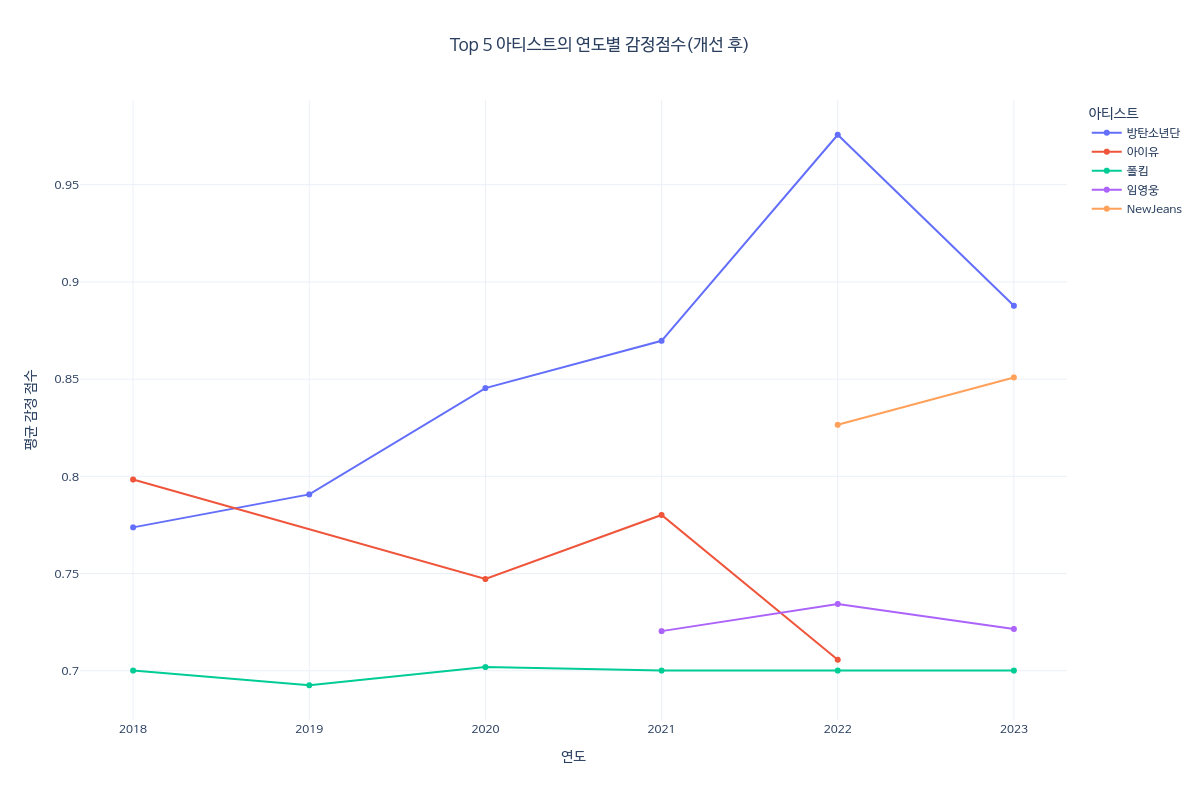

In [18]:
import plotly.express as px

# 특정 가수들의 리스트
top_5_singers = ['방탄소년단', '아이유', '폴킴', 'NewJeans', '임영웅']

# 해당 가수들의 데이터 필터링
filtered_data = melon_new[melon_new['singer'].isin(top_5_singers)]

# 연도별, 가수별 평균 감정 점수 계산
avg_sentiment_by_year = filtered_data.groupby(['Year', 'singer'])['sentiment_score'].mean().reset_index()

# Plotly 시각화
fig = px.line(avg_sentiment_by_year,
              x='Year',
              y='sentiment_score',
              color='singer',
              markers=True,
              title='Top 5 아티스트의 연도별 감정점수(개선 후)',
              labels={'sentiment_score': 'Average Sentiment Score', 'Year': 'Year'},
              template='plotly_white')

# 그래프 스타일 및 크기 조정
fig.update_layout(
    font_family="NanumBarunGothic",
    legend_title="아티스트",
    xaxis=dict(title="연도", tickangle=0),
    yaxis=dict(title="평균 감정 점수"),
    width=1200,  # 그래프 너비
    height=800,  # 그래프 높이
    title_x=0.5
)

# PNG로 렌더링 옵션
fig.show(renderer="png")  # PNG로 렌더링


연도별 평균 감정 점수 계산

In [19]:
avg_sentiment_by_year = df.groupby('Year')['sentiment_score'].mean().reset_index()

# 결과 출력
print(avg_sentiment_by_year)

     Year  sentiment_score
0  2018.0         0.743907
1  2019.0         0.735983
2  2020.0         0.754066
3  2021.0         0.757051
4  2022.0         0.770591
5  2023.0         0.792406


**연도별 평균 감정 점수(Average Sentiment Score)**를 나타내는 **선 그래프(Line Plot)입니다.**

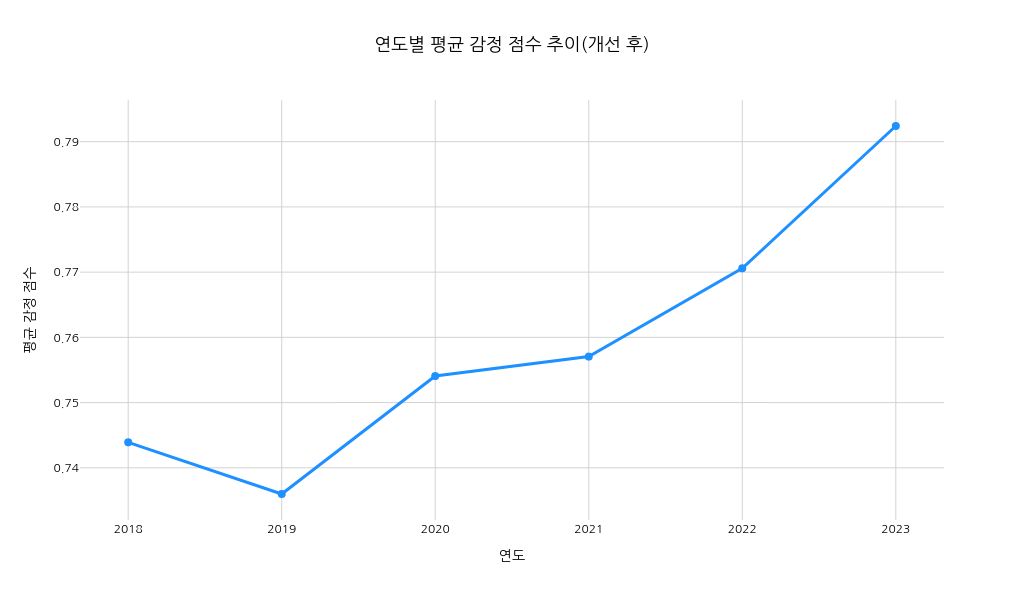

In [21]:
import plotly.graph_objects as go

# 시각화 (Line Plot)
fig = go.Figure()

# Line Plot 추가
fig.add_trace(go.Scatter(
    x=avg_sentiment_by_year['Year'],
    y=avg_sentiment_by_year['sentiment_score'],
    mode='lines+markers',
    line=dict(color='dodgerblue', width=3),
    marker=dict(color='dodgerblue', size=8)
))

# 그래프 제목과 레이블 설정
fig.update_layout(
    title='연도별 평균 감정 점수 추이(개선 후)',
    xaxis_title='연도',
    yaxis_title='평균 감정 점수',
    title_font_size=18,  # 제목 폰트 크기
    title_font=dict(family="NanumGothic", size=18, color="black"),
    title_x=0.5,
    xaxis_tickangle=45,
    font=dict(family="NanumGothic", size=12, color="black"),
    plot_bgcolor="white",
    paper_bgcolor="white",
    xaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray',
        tickangle=0
    ),
    yaxis=dict(
        showgrid=True,
        gridwidth=1,
        gridcolor='lightgray'
    ),
    showlegend=False,
    width=1024,
    height=600  #
)

# 그래프 출력
fig.show(renderer="png")
